In [112]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Optimizer
import math
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from sklearn.metrics import precision_score, recall_score, f1_score

class KineticDescent(Optimizer):
    def __init__(self, params, lr, gamma, c_init):
        defaults = dict(lr=lr, gamma=gamma)
        super(KineticDescent, self).__init__(params, defaults)
        self.p = {}
        self.c_init = c_init
        self.momentum_magnitude_history = []
        self.t = [0.]

    def initialize_momentum(self, param):
        p = torch.empty_like(param).uniform_(-1, 1)
        p = p / torch.norm(p, p=2)
        p = p * math.sqrt(2 * self.c_init)
        return p

    def solve_p(self, p, F, h, gamma):
        eps_reg = 1e-5  # Regularization term
        def compute_g(p, F):
            pdotF = torch.dot(p.flatten(), F.flatten())
            pdotp = torch.dot(p.flatten(), p.flatten()) + eps_reg
            return F - (pdotF / pdotp) * p - 0.5 * gamma * p
        g1 = compute_g(p, F)
        g2 = compute_g(p + 0.5 * h * g1, F)
        g3 = compute_g(p + 0.5 * h * g2, F)
        g4 = compute_g(p + h * g3, F)
        p1 = p + (h / 6) * (g1 + 2 * g2 + 2 * g3 + g4)
        return p1

    def kd_step(self, param, p, h, gamma):
        param.data.add_(0.5 * h * p)
        F = -param.grad
        p = self.solve_p(p, F, h, gamma)
        param.data.add_(0.5 * h * p)
        return p

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            h = group['lr']
            gamma = group['gamma']
            momentum_magnitude = 0
            for param in group['params']:
                if param.grad is None:
                    continue
                if param not in self.p:
                    self.p[param] = self.initialize_momentum(param)  # Initialize p
                momentum_magnitude += torch.dot(self.p[param].flatten(), self.p[param].flatten())
                self.p[param] = self.kd_step(param, self.p[param], h, gamma)
        self.momentum_magnitude_history.append(momentum_magnitude)
        self.t.append(self.t[-1] + h)
        return loss

In [72]:
def train(model, optimizer, criterion, scheduler, train_loader, num_epochs):
    train_loss_values = []
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        epoch_loss = 0
        for batch_inputs, batch_targets in train_loader:
            batch_inputs = batch_inputs.view(batch_inputs.size(0), -1)
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        scheduler.step()
        train_loss_values.append(epoch_loss / len(train_loader))
    return model, train_loss_values

def predict(model, loader):
    targets, predictions = [], []
    for batch_inputs, batch_targets in loader:
        batch_inputs = batch_inputs.view(batch_inputs.size(0), -1)
        outputs = model(batch_inputs)
        _, predicted = torch.max(outputs, 1)
        targets.extend(batch_targets.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())
    return targets, predictions

def evaluate(model, test_loader, train_loader):
    model.eval()
    with torch.no_grad():
        test_targets, test_predictions = predict(model, test_loader)
        train_targets, train_predictions = predict(model, train_loader)
    train_accuracy = 100. * (sum(1 for x, y in zip(train_predictions, train_targets) if x == y) / len(train_targets))
    test_accuracy = 100. * (sum(1 for x, y in zip(test_predictions, test_targets) if x == y) / len(test_targets))
    return train_accuracy, test_accuracy

In [114]:
model = nn.Sequential(
        nn.Linear(28 * 28, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    )
params = {
    'num_epochs': 100,
    'lr': 0.1,
    'gamma': 0.1,
    'c_init': 10.,
    's': 20,
    'g': 0.5
}

num_epochs = params['num_epochs']
lr = params['lr']
gamma = params['gamma']
c_init = params['c_init']
s = params['s']
g = params['g']

criterion = nn.CrossEntropyLoss()
optimizer = KineticDescent(model.parameters(), lr=lr, gamma=gamma, c_init=c_init)
#optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=s, gamma=g)
batch_size = 64
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model, train_loss_values = train(model, optimizer, criterion, scheduler, train_loader, num_epochs)
train_accuracy, test_accuracy = evaluate(model, test_loader, train_loader)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


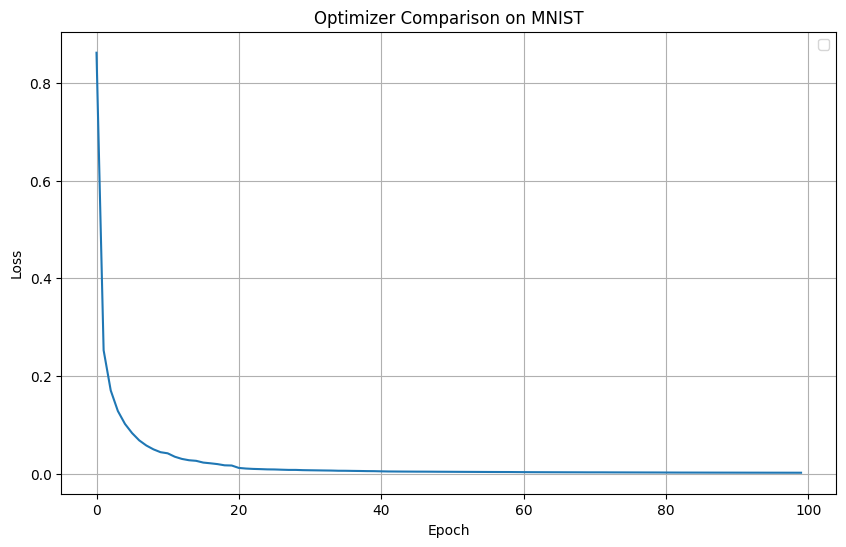

Train Accuracy: 99.99%, Test Accuracy: 96.91%


In [115]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(num_epochs), train_loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Optimizer Comparison on MNIST')
plt.legend()
plt.grid(True)
plt.show()

print(f"Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")#, Precision: {precision:.2f}%, Recall: {recall:.2f}%, F1-Score: {f1:.2f}%")